# 5a)

In this task, you will assess the visual appearance and accuracy of your generated samples.
Use only data from the Vervet1947 brain for the evaluation.


(a) Compute a Fr´echet Inception Distance (FID) score for 1000 samples of your gener-
ative model from task 3.

In [10]:
import torch
import torchvision
import matplotlib.pyplot as plt
from config.path import STORAGE
from dataset import create_dataloader
from torchvision.models import inception_v3

from transmittance2fom_genmodels.notebooks.Image_generation import Generator
from scipy.linalg import sqrtm
import numpy as np

# Load pre-trained models
generator_GAN = Generator(latent_dim=100, img_channels=3, Tile_size=64)
generator_GAN.load_state_dict(torch.load( STORAGE / 'GAN/generator_GAN.pth'))
generator_GAN.eval()

generator_WGAN = Generator(latent_dim=100, img_channels=3, Tile_size=64)
generator_WGAN.load_state_dict(torch.load(STORAGE / 'WGAN/generator_WGAN.pth'))
generator_WGAN.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "mps:0") # change to cpu 
generator_GAN.to(device)
generator_WGAN.to(device)


/var/folders/4g/91bm8hl51ld9v8c8tg6_lrqw0000gn/T/ipykernel_49879/463395702.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator_GAN.load_state_dict(torch.load( STO

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=65536, bias=True)
    (3): BatchNorm1d(65536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv_layers): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Sigmoid()
  )
)

In [11]:
# Function to generate images
def generate_images(generator, num_samples=1000, batch_size=16):
    generator.eval()
    images = []
    with torch.no_grad():
        for _ in range(num_samples // batch_size):
            z = torch.randn(batch_size, 100).to(device)
            generated_images = generator(z)
            images.append(generated_images.cpu())
    return torch.cat(images, dim=0)

# Generate 1000 samples
generated_images_GAN = generate_images(generator_GAN)
generated_images_WGAN = generate_images(generator_WGAN)

# Load real images from Vervet1947 brain
dataloader = create_dataloader(brain="Vervet1818", map_type="FOM", patch_size=64, batch_size=16)
real_images = []
for batch in dataloader:
    real_images.append(batch)
    if len(real_images) * 16 >= 1000:
        break
real_images = torch.cat(real_images, dim=0)[:1000]

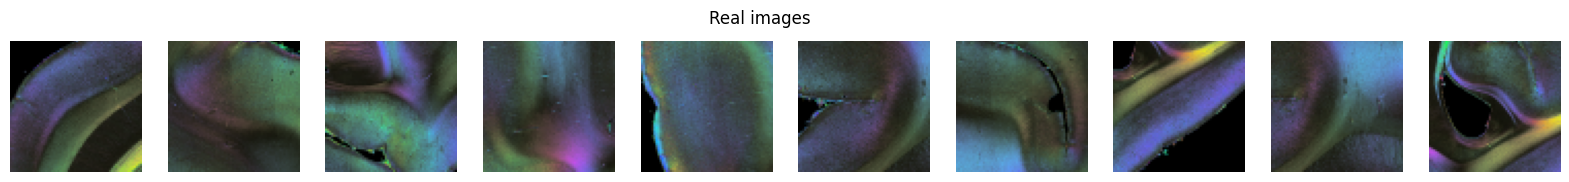

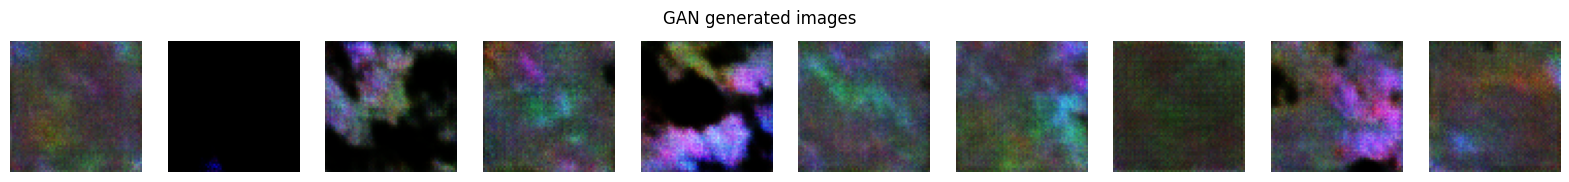

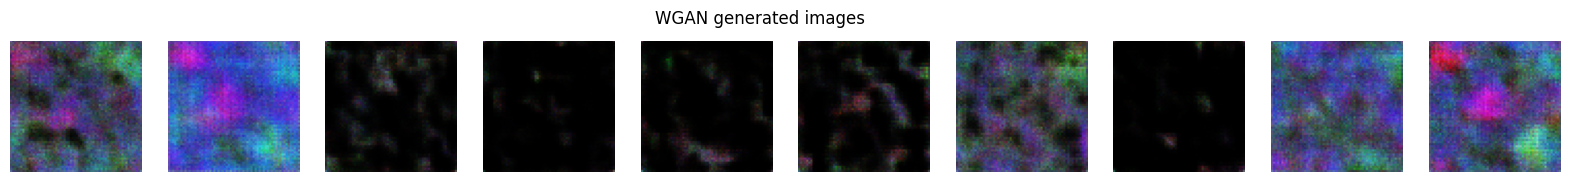

In [12]:
# display all 3 types of images subset of 10

def display_images(images, title):
    fig, ax = plt.subplots(1, 10, figsize=(20, 2))
    for i in range(10):
        ax[i].imshow(images[i].permute(1, 2, 0))
        ax[i].axis("off")
    fig.suptitle(title)
    plt.show()
    
display_images(real_images, "Real images")
display_images(generated_images_GAN, "GAN generated images")
display_images(generated_images_WGAN, "WGAN generated images")

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import inception_v3
import numpy as np
from scipy.linalg import sqrtm

def prepare_inception_model():
    model = inception_v3(pretrained=True, transform_input=False)
    # Remove the final classification layer
    model.fc = nn.Identity()
    model.eval()
    return model.to(device)

def get_inception_features(model, images, batch_size=32):
    """Extract features from the Inception model."""
    features = []
    n_batches = int(np.ceil(len(images) / batch_size))
    
    with torch.no_grad():
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(images))
            batch = images[start_idx:end_idx]
            
            # Ensure the tensor is float32 and on the correct device
            batch = batch.to(device, dtype=torch.float32)
            
            # Resize images to Inception input size (299x299)
            batch = F.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
            
            # Ensure pixel values are in [-1, 1]
            batch = (batch - 0.5) * 2
            
            try:
                # Extract features
                batch_features = model(batch)
                features.append(batch_features.cpu().numpy())
            except RuntimeError as e:
                print(f"Error processing batch {i}:")
                print(f"Batch shape: {batch.shape}")
                print(f"Batch dtype: {batch.dtype}")
                print(f"Batch device: {batch.device}")
                raise e
    
    return np.concatenate(features)


def calculate_fid(real_features, gen_features):
    # Calculate mean and covariance for both distributions
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = gen_features.mean(axis=0), np.cov(gen_features, rowvar=False)
    
    # Calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2) ** 2)
    
    # Calculate sqrt of product between covariances
    covmean = sqrtm(sigma1.dot(sigma2))
    
    # Check and correct imaginary components from numerical errors
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    # Calculate FID
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    
    return fid

In [14]:
# Before running the FID calculation, let's check the input tensors
print("Real images shape:", real_images.shape)
print("Real images dtype:", real_images.dtype)
print("Real images device:", real_images.device)
print("Real images value range:", real_images.min().item(), "-", real_images.max().item())

print("\nGAN images shape:", generated_images_GAN.shape)
print("GAN images dtype:", generated_images_GAN.dtype)
print("GAN images device:", generated_images_GAN.device)
print("GAN images value range:", generated_images_GAN.min().item(), "-", generated_images_GAN.max().item())

# Now try the FID calculation
inception_model = prepare_inception_model()
real_features = get_inception_features(inception_model, real_images)
gan_features = get_inception_features(inception_model, generated_images_GAN)
wgan_features = get_inception_features(inception_model, generated_images_WGAN)

# Calculate FID scores
fid_gan = calculate_fid(real_features, gan_features)
fid_wgan = calculate_fid(real_features, wgan_features)

print(f"FID score for GAN: {fid_gan:.2f}")
print(f"FID score for WGAN: {fid_wgan:.2f}")

Real images shape: torch.Size([1000, 3, 64, 64])
Real images dtype: torch.float32
Real images device: cpu
Real images value range: 0.0 - 0.9843137264251709

GAN images shape: torch.Size([992, 3, 64, 64])
GAN images dtype: torch.float32
GAN images device: cpu
GAN images value range: 3.756659080859771e-34 - 0.999991774559021
FID score for GAN: 206.76
FID score for WGAN: 275.08
